# Moving Average

- Calculate signal based on moving average crossover
- We will always by "in" a trade, either long or short, for this strategy

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
today = datetime.today()
one_year_ago = today - timedelta(days=365)

gld = yf.download('GLD', start=one_year_ago, end=today) # the gold ETF
day = np.arange(1, len(gld) + 1)
gld['day'] = day
gld.drop(columns=['Adj Close', 'Volume'], inplace = True)
gld = gld[['day', 'Open', 'High', 'Low', 'Close']]
gld.head()

[*********************100%%**********************]  1 of 1 completed


,day,Open,High,Low,Close
Date,,,,,
2023-07-10,1,178.369995,178.919998,178.259995,178.779999
2023-07-11,2,179.429993,179.710007,179.130005,179.449997
2023-07-12,3,181.179993,181.949997,181.100006,181.880005
2023-07-13,4,181.960007,182.149994,181.490005,182.009995
2023-07-14,5,181.589996,182.169998,181.110001,181.429993


In [3]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2023-07-10 to 2024-07-08
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     251 non-null    int64  
 1   Open    251 non-null    float64
 2   High    251 non-null    float64
 3   Low     251 non-null    float64
 4   Close   251 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.8 KB


In [4]:
# Fast Moving Average
num1 = 1
# Slow Moving Average
num2 = 10
gld['1-day'] = gld['Close'].rolling(num1).mean().shift() # shift() here is to roll moving average forward for 1 day to avoid implied look ahead
gld['10-day'] = gld['Close'].rolling(num2).mean().shift()
gld[num2-2:num2+3]

,day,Open,High,Low,Close,1-day,10-day
Date,,,,,,,
2023-07-20,9,183.729996,183.770004,182.470001,182.740005,183.669998,NaN
2023-07-21,10,182.059998,182.460007,181.679993,182.179993,182.740005,NaN
2023-07-24,11,182.220001,182.539993,181.339996,181.399994,182.179993,181.733998
2023-07-25,12,181.720001,182.470001,181.100006,182.410004,181.399994,181.995998
2023-07-26,13,182.660004,183.639999,182.309998,183.300003,182.410004,182.291998


In [5]:
# Add "signal" column
# Long
gld['signal'] = np.where(gld['1-day'] > gld['10-day'], 1, 0)
# Short
gld['signal'] = np.where(gld['1-day'] < gld['10-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,day,Open,High,Low,Close,1-day,10-day,signal
Date,,,,,,,,
2023-07-24,11,182.220001,182.539993,181.339996,181.399994,182.179993,181.733998,1
2023-07-25,12,181.720001,182.470001,181.100006,182.410004,181.399994,181.995998,-1
2023-07-26,13,182.660004,183.639999,182.309998,183.300003,182.410004,182.291998,1
2023-07-27,14,181.639999,181.639999,180.320007,180.419998,183.300003,182.433998,1
2023-07-28,15,181.479996,182.270004,181.250000,181.860001,180.419998,182.274998,-1


In [6]:
gld['return'] = np.log(gld['Close']).diff() # Buy and hold
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.head()

,day,Open,High,Low,Close,1-day,10-day,signal,return,system_return,entry
Date,,,,,,,,,,,
2023-07-24,11,182.220001,182.539993,181.339996,181.399994,182.179993,181.733998,1,NaN,NaN,NaN
2023-07-25,12,181.720001,182.470001,181.100006,182.410004,181.399994,181.995998,-1,0.005552,-0.005552,-2.0
2023-07-26,13,182.660004,183.639999,182.309998,183.300003,182.410004,182.291998,1,0.004867,0.004867,2.0
2023-07-27,14,181.639999,181.639999,180.320007,180.419998,183.300003,182.433998,1,-0.015837,-0.015837,0.0
2023-07-28,15,181.479996,182.270004,181.250000,181.860001,180.419998,182.274998,-1,0.007950,-0.007950,-2.0


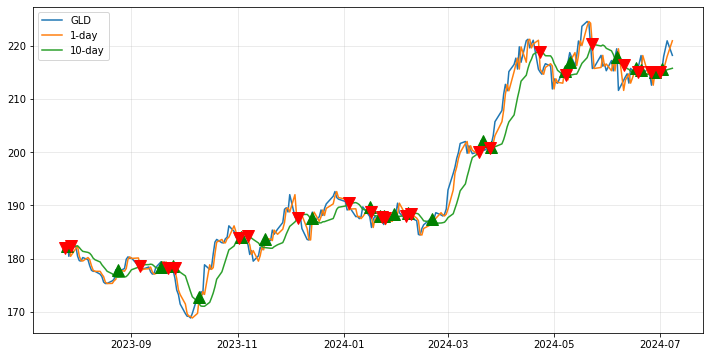

In [7]:
# Plot trades on time series
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-252:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-252:]['1-day'], label = '1-day')
plt.plot(gld.iloc[-252:]['10-day'], label = '10-day')
plt.plot(gld[-252:].loc[gld.entry == 2].index, gld[-252:]['1-day'][gld.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.entry == -2].index, gld[-252:]['10-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

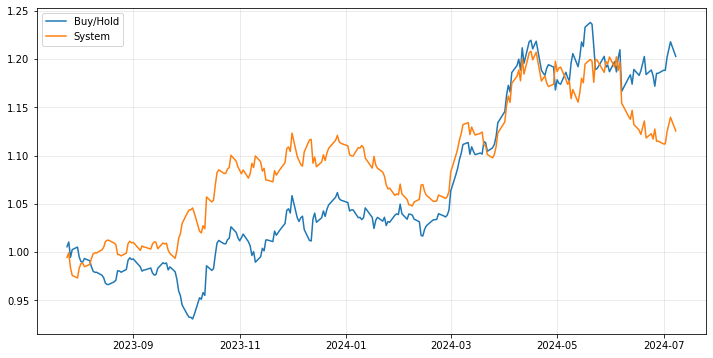

In [8]:
# Compare to buy and hold strategy
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [9]:
# Buy and hold
np.exp(gld['return']).cumprod()[-1] -1 # Just today

0.20281152030201222

In [10]:
# The strategy
np.exp(gld['system_return']).cumprod()[-1] -1 # Just today

0.12559730600503105